# Split long words and correct spelling on small ones (<=15 characters)

In [1]:
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
from data_preparation import loadData, SentenceSplitter

## Load text words

In [33]:
_, _, contestTrain, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


In [36]:
data = pd.concat([
    SentenceSplitter("comment_text").transform(contestTrain),
    SentenceSplitter("comment_text").transform(contestTest)])

Splitting sentences...
Splitting sentences...


In [37]:
textWords = set([word for sentence in data for word in sentence])

In [39]:
len(textWords)

385116

## Load small embedding

In [40]:
embedding = KeyedVectors.load("../../state/external-models/glove.6B/saved-2300.bin", mmap="r")

In [41]:
embeddingWords = embedding.vocab.keys()

In [42]:
len(embeddingWords)

2196016

## Missing words count and distribution

In [43]:
missingWords = textWords - embeddingWords
print("Missing {} words out of total {} words. This is {}% of the words!".format(
    len(missingWords), 
    len(textWords),
    int(len(missingWords) / len(textWords) * 100)))

Missing 245696 words out of total 385116 words. This is 63% of the words!


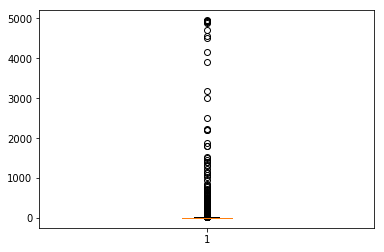

In [44]:
import matplotlib.pyplot as plt

plt.boxplot([len(word) for word in missingWords])

plt.show()

In [45]:
len([word for word in missingWords if len(word) >= 1000])

34

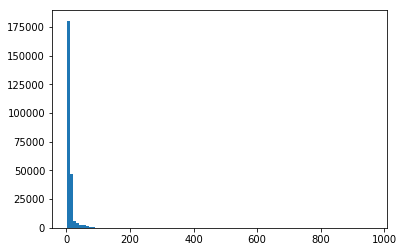

In [46]:
plt.hist([len(word) for word in missingWords if len(word) < 1000], bins=100)

plt.show()

In [47]:
len([word for word in missingWords if len(word) >= 100])

904

In [48]:
# This is how large an 100 char word is!!
len("sgfdgfdglgdsgfdggfdgghdggsdggfdhgfdfdggfdghgsafldsfdsfdsfdsfdsfdsfdsffdssafsFEGFFDGFDSGFDgfdgfdsfdsf")

100

In [49]:
# This is a 24 char word
len("Pozessorgeschwindichkeit")

24

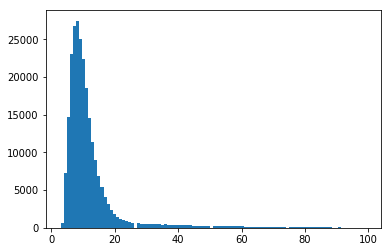

In [50]:
plt.hist([len(word) for word in missingWords if len(word) < 100], bins=100)

plt.show()

In [51]:
len([len(word) for word in missingWords if len(word) < 20]) / len(missingWords)

0.9062377897890076

In [52]:
len([len(word) for word in embeddingWords if len(word) < 20]) / len(embeddingWords)

0.9899640986222322

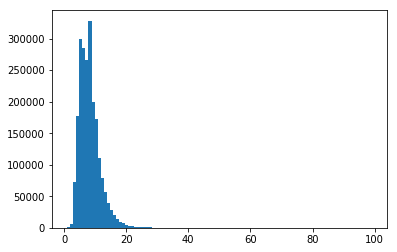

In [53]:
# Histogram of 'normal' words
plt.hist([len(word) for word in embeddingWords if len(word) < 100], bins=100)

plt.show()

In [54]:
list(missingWords)[0:30]

['intercoursejpg',
 'courtcases',
 'maskvos',
 'templateislamic',
 'minoriites',
 'sprachbarrieren',
 'talkcherry',
 'httpwebsniffernet',
 'catiii',
 'curcuruto',
 'gnxbfxghbhccjhchkcyu',
 'wankmerchant',
 'erklren',
 'usertristanbogard',
 'wpfaqbusiness',
 'footwalking',
 'conrtibutions',
 'gaandoooooooooooooooooooo',
 'thankuyou',
 'tadoussac',
 'congradafuckinglations',
 'httpissuucomnorthernvalleysnewsdocsnvnmay',
 'stengels',
 'myxsolar',
 'kiryat',
 'sugaarsaludos',
 'historianclassicist',
 'buffalonickeltypeobversepng',
 'alifantis',
 'montanawestern']

## Word distance

In [55]:
import editdistance

In [56]:
def closestEditWord(inputWord, dictionaries):
    result = None
    for word in dictionaries[len(inputWord)]:
        if editdistance.eval(word, inputWord) <= 1:
            result = [word]
            break
    return result

In [57]:
cutSize = 15

smallWords = [word for word in missingWords if len(word) <= cutSize]
largeWords = [word for word in missingWords if len(word) > cutSize]

In [58]:
smallEmbeddingWords = [word for word in embeddingWords if len(word) <= 17]

In [59]:
dicts = {i: list(filter(lambda w: (len(w) <= i + 1) and (len(w) >= i - 1), smallEmbeddingWords)) for i in range(2, 16) }

In [60]:
%%time
from multiprocessing import Pool

def closestWord(indexedWord):
    index, word = indexedWord
    if index % 1000 == 0:
        print("{}/{} words...".format(index, len(smallWords)))
        
    return (word, closestEditWord(word, dicts))

with Pool(processes=4) as pool:
    closestWords = pool.map(closestWord, list(enumerate(smallWords[:50])))

0/207751 words...
CPU times: user 20 ms, sys: 540 ms, total: 560 ms
Wall time: 17 s


## Split words without space

In [61]:
from math import log
wordcost = dict((k, log((i+1)*log(len(embeddingWords)))) for i,k in enumerate(embeddingWords))
maxword = max(len(x) for x in embeddingWords)

def inferSpaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return list(reversed(out))

In [62]:
%%time
wordsToSplit = [word[0] for word in closestWords if word[1] == None] + largeWords
splitWords = [(word, inferSpaces(word)) for word in wordsToSplit]

CPU times: user 2min 16s, sys: 36 ms, total: 2min 16s
Wall time: 2min 16s


In [63]:
%%time
missingWordsResolutionDictionary = dict(splitWords + [word for word in closestWords if word[1] != None])

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 13.9 ms


In [64]:
import pickle

def saveObject(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f, 0)

In [65]:
saveObject(missingWordsResolutionDictionary, "./missingWordsResolution.plk")

In [151]:
def loadObject(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [152]:
sanityCheck = loadObject("./missingWordsResolution.plk")